# **Histopathologic Cancer Detection (Kaggle)**

### **Kaggle competition description**

The Histopathologic Cancer Detection competition on Kaggle was a prominent **binary image classification** challenge in the field of medical imaging.

* **Task Type:** Binary Classification. For each image patch, the model had to predict a probability that the patch contains metastatic tissue ($\text{label} = 1$) or not ($\text{label} = 0$).

* **Dataset Source:** The data was a slightly modified version of the **PatchCamelyon (PCam)** benchmark dataset, which itself is derived from the larger Camelyon16 Challenge.
* **Image Patches:** Competitors worked with a large number of **$96 \times 96$ pixel color image patches** extracted from histopathologic scans of lymph node sections.

* **Evaluation Metric:** Submissions were evaluated on the **Area Under the Receiver Operating Characteristic Curve (AUC)**. This metric was chosen because it measures the model's ability to distinguish between the two classes (cancer/no cancer) across all possible classification thresholds, which is crucial in a diagnostic setting.



### **Project Objective**

To build a deep learning model that accurately identifies metastatic cancer tissue in 96x96px histopathologic image patches.


### **Project Workflow**
1. Load data
2. EDA
3. Modeling
4. Evaluation



## 1. Setup & Configuration
Import libraries and set system configuration

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras  # 导入 Keras 3.0
from sklearn.model_selection import train_test_split

# --- 1. 配置 ---

# 设置 Keras 3.0 后端为 TensorFlow
# 你需要在导入 keras 之前设置这个环境变量
os.environ["KERAS_BACKEND"] = "tensorflow"

# 全局常量，用于快速迭代
# 竞赛的图像尺寸是 96x96
IMAGE_SIZE = 96
# 鉴于你的 GPU RAM 很大 (80GB)，你可以使用一个非常大的批量
BATCH_SIZE = 4096
# 快速迭代时，先设置一个较小的 epoch 数
EPOCHS = 10
SEED = 42

# 设置随机种子以保证可复现性
tf.random.set_seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [3]:
print(f"--- Keras 3.0 ---")
print(f"Using Keras backend: {keras.backend.backend()}")
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")


--- Keras 3.0 ---
Using Keras backend: tensorflow
Keras version: 3.10.0
TensorFlow version: 2.19.0


## 2. Data Setup
* **Download data from my google drive**

In [4]:
# 安装 gdown，如果尚未安装
!pip install gdown -q

In [5]:
import os

# 从你提供的链接中提取文件 ID
FILE_ID = '17ePgtixsbe2Cxz2ZgYSsng6TwvH8KUKB'

# 我们要下载并解压到 Colab 本地的临时路径
LOCAL_DATA_PATH = "/content/data"

# ZIP 文件在本地的保存路径
LOCAL_ZIP_PATH = os.path.join(LOCAL_DATA_PATH, "histopathologic-cancer-detection.zip")

# 我们用标签文件作为“是否已解压”的检查点
CHECK_FILE_PATH = os.path.join(LOCAL_DATA_PATH, "train_labels.csv")

# --- 1. 检查是否已下载和解压，如果未下载，则执行下载和解压 ---
if not os.path.exists(CHECK_FILE_PATH):
    print(f"在 {LOCAL_DATA_PATH} 未找到数据...")
    print(f"正在从 Google Drive (ID: {FILE_ID}) 下载文件...")

    # 确保目标目录存在
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

    # 使用 gdown 下载文件
    # --id 参数用于指定 Google Drive 文件 ID
    # --fuzzy 参数可以在文件名不完全匹配时尝试下载
    !gdown --id "$FILE_ID" -O "$LOCAL_ZIP_PATH" --fuzzy

    print("下载完成！")
    print(f"正在解压文件到 {LOCAL_DATA_PATH}...")

    # 解压到 Colab 本地 (-q 参数是“安静模式”，减少输出)
    !unzip -q "$LOCAL_ZIP_PATH" -d "$LOCAL_DATA_PATH"

    print("解压完成！")
else:
    print(f"数据已存在于 {LOCAL_DATA_PATH}。跳过下载和解压。")

# --- 2. 设置你代码中使用的路径 ---
# BASE_PATH 现在指向 Colab 的本地路径
BASE_PATH = LOCAL_DATA_PATH

# 模型权重路径
MODEL_WEIGHTS_PATH = "/content/weights"
if not os.path.exists(MODEL_WEIGHTS_PATH):
    os.makedirs(MODEL_WEIGHTS_PATH)

在 /content/data 未找到数据...
正在从 Google Drive (ID: 17ePgtixsbe2Cxz2ZgYSsng6TwvH8KUKB) 下载文件...
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17ePgtixsbe2Cxz2ZgYSsng6TwvH8KUKB
From (redirected): https://drive.google.com/uc?id=17ePgtixsbe2Cxz2ZgYSsng6TwvH8KUKB&confirm=t&uuid=2324ca4b-9123-4e5d-a3aa-a461639b3d9d
To: /content/data/histopathologic-cancer-detection.zip
100% 6.77G/6.77G [01:55<00:00, 58.8MB/s]
下载完成！
正在解压文件到 /content/data...
解压完成！


* **Convert image format from tif to png**
  * The original format of histopathologic images is tif, but there are some compatible issue of handling tif format images while combine those data into tf dataset.
  * To solve that annoying compatible issue, I choose to handle png image instead of tif image.

In [6]:
import os
import pandas as pd
from PIL import Image
from joblib import Parallel, delayed
from tqdm import tqdm

# --- 配置 ---

# 原始 TIF 图像所在的路径
TIF_TRAIN_DIR = '/content/data/train/'
# 标签 CSV 文件
LABELS_CSV_PATH = '/content/data/train_labels.csv'

# 你想要保存新 PNG 图像的路径
PNG_TRAIN_DIR = '/content/data/train_png/'

# 并行处理的核心数 (-1 = 使用所有核心)
N_JOBS = -1

# --- 转换函数 ---

def convert_image(tif_path, png_path):
    """
    读取 TIF 文件并将其另存为 PNG。
    """
    try:
        # 使用 Pillow 打开 TIF 图像
        img = Image.open(tif_path)

        # 确保图像是 RGB 模式（丢弃 alpha 通道等）
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # 以 PNG 格式保存
        img.save(png_path, 'PNG')

    except Exception as e:
        print(f"Error converting {tif_path}: {e}")
        # 如果单个文件损坏，跳过它
        return None
    return png_path

# --- 主执行函数 ---

def convert_all():
    print("Starting TIF to PNG conversion...")

    # 1. 确保目标目录存在
    os.makedirs(PNG_TRAIN_DIR, exist_ok=True)

    # 2. 加载标签文件以获取所有文件名
    try:
        all_labels_df = pd.read_csv(LABELS_CSV_PATH)
    except FileNotFoundError:
        print(f"Error: Cannot find labels file at {LABELS_CSV_PATH}")
        return

    total_images = len(all_labels_df)
    print(f"Found {total_images} images to potentially convert.")

    # --- 新增检查：如果 PNG 目录已满，则跳过转换 ---
    existing_png_files = len([name for name in os.listdir(PNG_TRAIN_DIR) if name.endswith('.png')])
    if existing_png_files == total_images:
        print(f"PNG images already exist in {PNG_TRAIN_DIR}. Skipping conversion.")
        return
    # --- 检查结束 ---


    # 3. 创建任务列表
    # tasks 是一个 (tif_path, png_path) 的元组列表
    tasks = []
    for img_id in all_labels_df['id']:
        tif_path = os.path.join(TIF_TRAIN_DIR, img_id + '.tif')
        png_path = os.path.join(PNG_TRAIN_DIR, img_id + '.png')
        # 只添加那些目标 PNG 文件不存在的任务
        if not os.path.exists(png_path):
             tasks.append((tif_path, png_path))


    if not tasks:
        print("No new images to convert.")
        return

    print(f"Found {len(tasks)} images to convert.")
    print(f"Starting parallel conversion with {N_JOBS} jobs...")

    # 4. 执行并行转换
    # 使用 joblib.Parallel 来并行化 `convert_image` 函数
    # tqdm 用于显示进度条
    results = Parallel(n_jobs=N_JOBS)(
        delayed(convert_image)(tif_path, png_path)
        for tif_path, png_path in tqdm(tasks, desc="Converting Images")
    )

    # 5. 总结
    success_count = sum(1 for r in results if r is not None)
    fail_count = len(results) - success_count

    print("\n--- Conversion Summary ---")
    print(f"Total images processed in this run: {len(results)}")
    print(f"Successfully converted: {success_count}")
    print(f"Failed to convert: {fail_count}")
    print(f"PNG images are saved in: {PNG_TRAIN_DIR}")

convert_all()

Starting TIF to PNG conversion...
Found 220025 images to potentially convert.
Found 220025 images to convert.
Starting parallel conversion with -1 jobs...


Converting Images: 100%|██████████| 220025/220025 [13:50<00:00, 265.06it/s]



--- Conversion Summary ---
Total images processed in this run: 220025
Successfully converted: 220025
Failed to convert: 0
PNG images are saved in: /content/data/train_png/


* **Generate pandas DataFrame for later use**
  * The lable of each date entry is stored in csv file, but the image is store in tif or png format of picture.
  * I need a dataframe that combines the image itself with the image ID.
  * The "id" variable is the bridge of the image id and the image itself.
  * The "filename" variable is the location of the corresponding imamge, where the image stored in this colab runtime environment.

In [7]:
TRAIN_DATA_DIR = os.path.join(BASE_PATH, "train_png")
TEST_DATA_DIR = os.path.join(BASE_PATH, "test")
LABELS_CSV_PATH = os.path.join(BASE_PATH, "train_labels.csv")


if not os.path.exists(TRAIN_DATA_DIR) or not os.path.exists(LABELS_CSV_PATH):
    print(f"Error: Data paths not found.")
    print(f"Please check: \nTRAIN_DATA_DIR = {TRAIN_DATA_DIR}")
    print(f"LABELS_CSV_PATH = {LABELS_CSV_PATH}")

# 1. 加载和拆分数据
print("Loading and splitting data...")
all_labels_df = pd.read_csv(LABELS_CSV_PATH)

# 创建 'filename' 列，包含完整的图像路径
all_labels_df['filename'] = all_labels_df['id'].apply(
    lambda x: os.path.join(TRAIN_DATA_DIR, x + '.png')
)

# 将标签转换为整数
all_labels_df['label'] = all_labels_df['label'].astype(int)


print(f"Total training samples: {len(all_labels_df)}")
all_labels_df.head()

Loading and splitting data...
Total training samples: 220025


,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,/content/data/train_png/f38a6374c348f90b587e04...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/content/data/train_png/c18f2d887b7ae4f6742ee4...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/content/data/train_png/755db6279dae599ebb4d39...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/content/data/train_png/bc3f0c64fb968ff4a8bd33...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/content/data/train_png/068aba587a4950175d04c6...


## 3. EDA

* **Check wheher the dataset is balanced or not.**
  * The ratio of the labels is 60% : 40%, which is somewhat balanced. So we don't have to pay much attention on it.

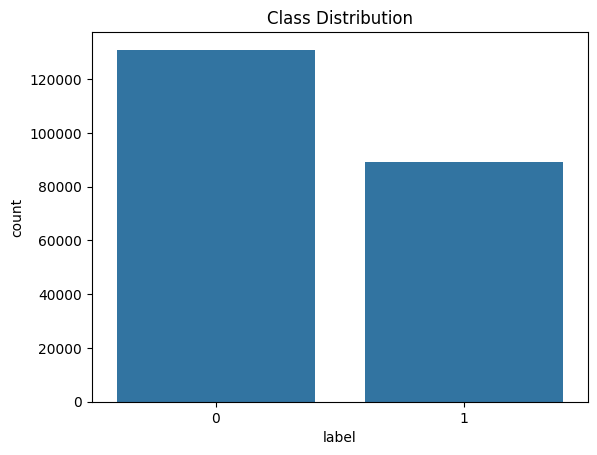

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=all_labels_df)
plt.title('Class Distribution')
plt.show()
print(all_labels_df['label'].value_counts(normalize=True))

* **View Sample Images**
  * Visualize some positive and negative samples.
  * I'm a complete novice in medicine. Therefore, I have absolutely no way of visually distinguishing between cancer cells and normal cells. This is a significant disadvantage for me in doing this project.

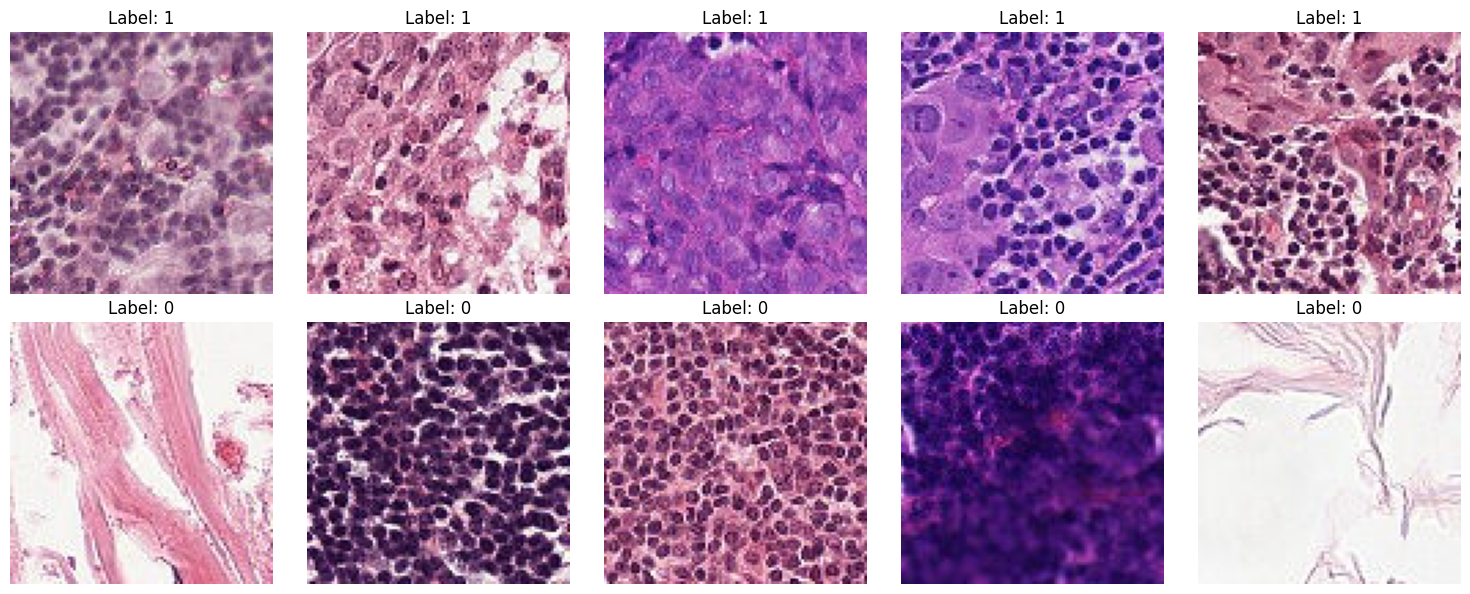

In [9]:
def plot_samples(df, n=5):
    """Plots n positive and n negative samples."""
    pos_samples = df[df['label'] == 1]['filename'].sample(n, random_state=SEED).values
    neg_samples = df[df['label'] == 0]['filename'].sample(n, random_state=SEED).values

    fig, axes = plt.subplots(2, n, figsize=(n*3, 6))

    for i in range(n):
        # Plot positive samples
        img_pos = plt.imread(pos_samples[i])
        axes[0, i].imshow(img_pos)
        axes[0, i].set_title("Label: 1")
        axes[0, i].axis('off')

        # Plot negative samples
        img_neg = plt.imread(neg_samples[i])
        axes[1, i].imshow(img_neg)
        axes[1, i].set_title("Label: 0")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples (only if not in debug mode, or if debug df is large enough)
if len(all_labels_df) > 10:
    plot_samples(all_labels_df)
else:
    print("Skipping sample plotting due to small debug dataframe.")

* **Data Cleaning**
  * I found out via the help of Gemini pro that this dataset is known to contain anomalies (e.g., blank slides, slides with markers, duplicates).
  * A simple cleaning step is to remove images with very low variance, as they are often blank.
  * I've visualized the 10 samples with the lowest variance. As you can see, the data cleaning step is neccessary for this dataset.

Starting data cleaning (calculating variance)... This may take a while.
Utilizing 2 CPU cores for parallel variance calculation.


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 2564 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done 8324 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done 16388 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done 26756 tasks      | elapsed:   28.6s
[Parallel(n_jobs=2)]: Done 39428 tasks      | elapsed:   41.6s
[Parallel(n_jobs=2)]: Done 54404 tasks      | elapsed:   56.2s
[Parallel(n_jobs=2)]: Done 71684 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 91268 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 113156 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 137348 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 163844 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 192644 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 220025 out of 220025 | elapsed:  4.1min finished


Variance calculation complete.
Displaying 10 samples with the lowest variance...


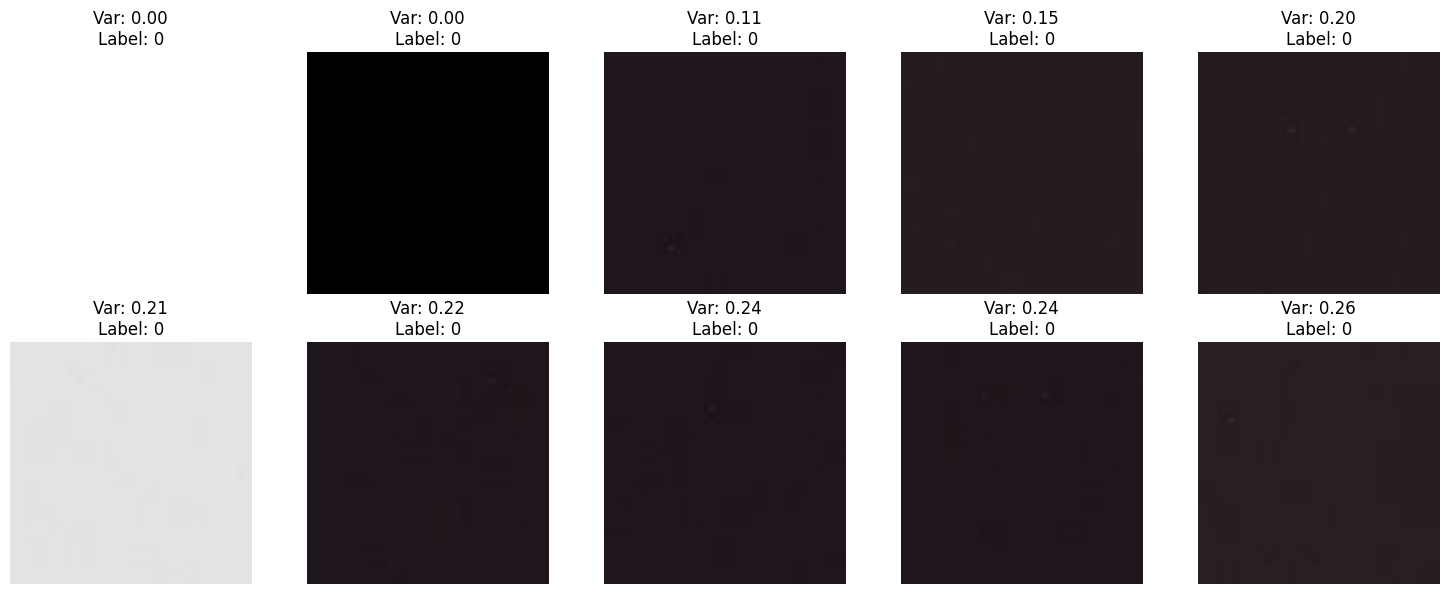

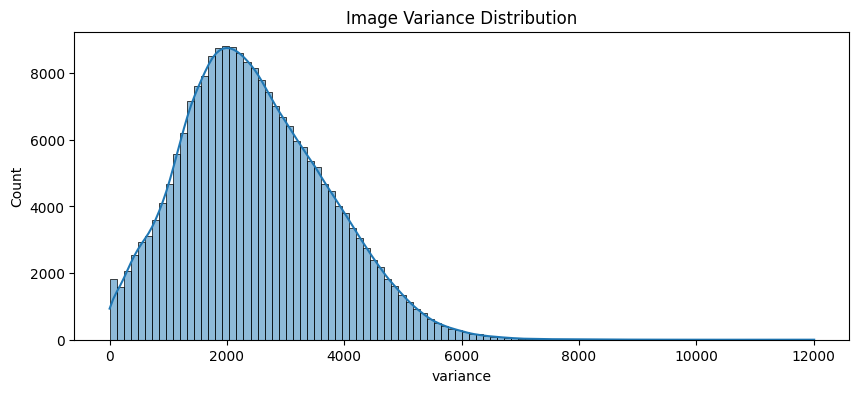

--- Data Cleaning Report ---
Original sample count (all_labels_df): 220025
Removed 1628 low-variance images (var < 100).
New sample count (all_labels_df_clean): 218397


In [10]:
# [CODE CELL]
import cv2 # <-- 重新导入以确保此单元格能独立运行
from joblib import Parallel, delayed # <-- 导入 Joblib
import os # <-- 导入 os 以获取 CPU 核心数
import matplotlib.pyplot as plt # <-- 导入 plt

# This step can be slow. For a quick run (DEBUG=True), we might skip it or run on the sample.
# For the full dataset, this should be run once.

def get_image_variance(image_path):
    """Calculates the variance of a single image."""
    try:
        # Read image in grayscale which is enough for variance calculation
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            return 0
        return image.var()
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return 0

print("Starting data cleaning (calculating variance)... This may take a while.")

# --- 优化：并行处理 ---
# 利用 Colab Pro 的多核心 CPU 和高 RAM
# 替代慢速的: df_labels['file_path'].apply(get_image_variance)

n_cores = os.cpu_count()
print(f"Utilizing {n_cores} CPU cores for parallel variance calculation.")

paths_to_process = all_labels_df['filename'].values

# 使用 joblib 并行运行, verbose=5 会显示进度
variances = Parallel(n_jobs=n_cores, verbose=5)(
    delayed(get_image_variance)(path) for path in paths_to_process
)

# 将结果分配回 dataframe
all_labels_df['variance'] = variances

print("Variance calculation complete.")

# --- 1. (新增) 可视化方差最低的10个样本 ---
print("Displaying 10 samples with the lowest variance...")
low_variance_samples = all_labels_df.sort_values(by='variance').head(10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, (idx, row) in enumerate(low_variance_samples.iterrows()):
    try:
        img = plt.imread(row['filename'])
        axes[i].imshow(img)
        axes[i].set_title(f"Var: {row['variance']:.2f}\nLabel: {row['label']}")
        axes[i].axis('off')
    except Exception as e:
        axes[i].set_title(f"Error loading img: {row['id']}")
        print(e)
plt.tight_layout()
plt.show()

# Plot variance distribution
plt.figure(figsize=(10, 4))
sns.histplot(all_labels_df['variance'], bins=100, kde=True)
plt.title('Image Variance Distribution')
plt.show()

# --- 2. (修改) 过滤低方差图像并使用新变量 ---
VARIANCE_THRESHOLD = 100 # This is a common threshold, can be tuned
original_count = len(all_labels_df)

# 将清理后的数据存储在新 DataFrame 'df_labels_clean' 中
all_labels_df_clean = all_labels_df[all_labels_df['variance'] > VARIANCE_THRESHOLD].reset_index(drop=True)
new_count = len(all_labels_df_clean)

print(f"--- Data Cleaning Report ---")
print(f"Original sample count (all_labels_df): {original_count}")
print(f"Removed {original_count - new_count} low-variance images (var < {VARIANCE_THRESHOLD}).")
print(f"New sample count (all_labels_df_clean): {new_count}")



## 4. Build model

* **Split the dataset into train set and valiation set at first.**

In [18]:
# 拆分训练集和验证集 (80/20)
# 使用 stratify 来保持标签分布

FRAC=0.001
debug_df = all_labels_df_clean.sample(frac=FRAC, random_state=SEED).reset_index(drop=True)

print(f"Original sample count (all_labels_df_clean): {len(all_labels_df_clean)}")
print(f"Debug sample count (debug_df): {len(debug_df)}")

DEBUG_MODE=1
if DEBUG_MODE:
    print("Enter debug mode: use only portion of data")
    all_df = debug_df
else:
    all_df = all_labels_df_clean

train_df, val_df = train_test_split(
    all_df,
    test_size=0.2,
    random_state=SEED,
    stratify=all_df['label']
)

print(f"Total samples: {len(all_df)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Original sample count (all_labels_df_clean): 218397
Debug sample count (debug_df): 218
Enter debug mode: use only portion of data
Total samples: 218
Training samples: 174
Validation samples: 44


* **Genearte tf dataset for later model building and evaluation**

In [12]:

def parse_image(filename, label):
    """
    加载并预处理单个 PNG 图像。
    """
    image = tf.io.read_file(filename)

    # 关键更改：使用 decode_png，并确保 channels=3
    # 这将确保 (96, 96, 3) 的形状
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image, label




def create_dataset(df, is_training=True):
    """
    根据 DataFrame 创建一个 tf.data.Dataset。
    """
    # 从 DataFrame 的 'filename' 和 'label' 列创建数据集
    dataset = tf.data.Dataset.from_tensor_slices((df['filename'].values, df['label'].values))

    # 使用多核并行处理图像
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        # 仅在训练时：
        # 1. 缓存数据（如果内存允许）
        # 2. 打乱数据
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=len(df), seed=SEED)

    # 批量处理
    dataset = dataset.batch(BATCH_SIZE)

    if not is_training:
        # 验证集在批处理后缓存，以加快评估速度
        dataset = dataset.cache()

    # 预取数据以获得最佳性能
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset



In [19]:

# 2. 创建 tf.data pipelines
print("Creating data pipelines...")
train_dataset = create_dataset(train_df, is_training=True)
val_dataset = create_dataset(val_df, is_training=False)
print("Data pipelines created.")

Creating data pipelines...
Data pipelines created.


* **leverage transfer learning by Building models on top of base models**
  * The base models are **MobileNetV3Small**, **EfficientNetV2B0**, **ResNet50V2**
  * Compare the three models and select the best model for later use

In [14]:

# --- 3. 模型构建 ---

def build_augmentation_model():
    """
    创建包含 Keras 预处理层的数据增强模型。
    这将利用 GPU 进行加速。
    """
    return keras.Sequential([
        keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
        keras.layers.RandomRotation(0.2, seed=SEED),
        keras.layers.RandomZoom(0.2, seed=SEED),
        keras.layers.RandomTranslation(0.2, 0.2, seed=SEED),
    ], name="augmentation_model")


def build_model(base_model_name, augmentation_model):
    """
    构建一个用于训练的模型。
    主干网络初始时被冻结。

    返回:
        model (keras.Model): 完整的、可编译的模型。
        base_model (keras.Model): 对基础模型 (e.g., MobileNet) 的引用，用于稍后解冻。
    """
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # 1. 数据增强层
    x = augmentation_model(inputs)

    # 2. 选择基础模型
    # **重要**: base_model 在这里被定义
    if base_model_name == 'MobileNetV3Small':
        base_model = keras.applications.MobileNetV3Small(
            include_top=False, weights='imagenet', input_tensor=x
        )
    elif base_model_name == 'EfficientNetV2B0':
        base_model = keras.applications.EfficientNetV2B0(
            include_top=False, weights='imagenet', input_tensor=x
        )
    elif base_model_name == 'ResNet50V2':
        base_model = keras.applications.ResNet50V2(
            include_top=False, weights='imagenet', input_tensor=x
        )
    else:
        raise ValueError(f"Unknown base model: {base_model_name}")

    # 3. 初始时冻结主干网络
    base_model.trainable = False

    # 4. 添加分类头
    # (重命名 'x' 以避免与增强层的 'x' 混淆)
    x_head = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x_head = keras.layers.BatchNormalization()(x_head)
    x_head = keras.layers.Dropout(0.3)(x_head)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x_head)

    # 5. 创建完整模型
    model = keras.Model(inputs=inputs, outputs=outputs)

    # 6. 编译模型 (用于阶段 1)
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    metrics = [
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
    ]

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=metrics
    )

    # **修改**: 返回 model 和 base_model
    return model, base_model

Starting model training loop...

--- Training MobileNetV3Small ---


/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4138 - auc: 0.3769 - loss: 1.2172 - val_accuracy: 0.4091 - val_auc: 0.2484 - val_loss: 0.8936 - learning_rate: 0.0010
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4310 - auc: 0.4243 - loss: 1.0754 - val_accuracy: 0.4318 - val_auc: 0.2640 - val_loss: 0.8788 - learning_rate: 0.0010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4253 - auc: 0.4118 - loss: 1.0689 - val_accuracy: 0.4318 - val_auc: 0.2867 - val_loss: 0.8630 - learning_rate: 0.0010
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4483 - auc: 0.4246 - loss: 1.0316 - val_accuracy: 0.4318 - val_auc: 0.3188 - val_loss: 0.8487 - learning_rate: 0.0010
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step - accuracy: 0.4598 - auc: 0.4218 - loss: 1.0692 - val_accuracy: 0.4318 - val_auc: 0.3406 - val_loss: 0.8343 - learning_rate: 0.0010
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - auc: 0.4596 - loss: 0.9941 - val

,Model,Best_Val_AUC
1,EfficientNetV2B0,0.665631
2,ResNet50V2,0.621118
0,MobileNetV3Small,0.449275


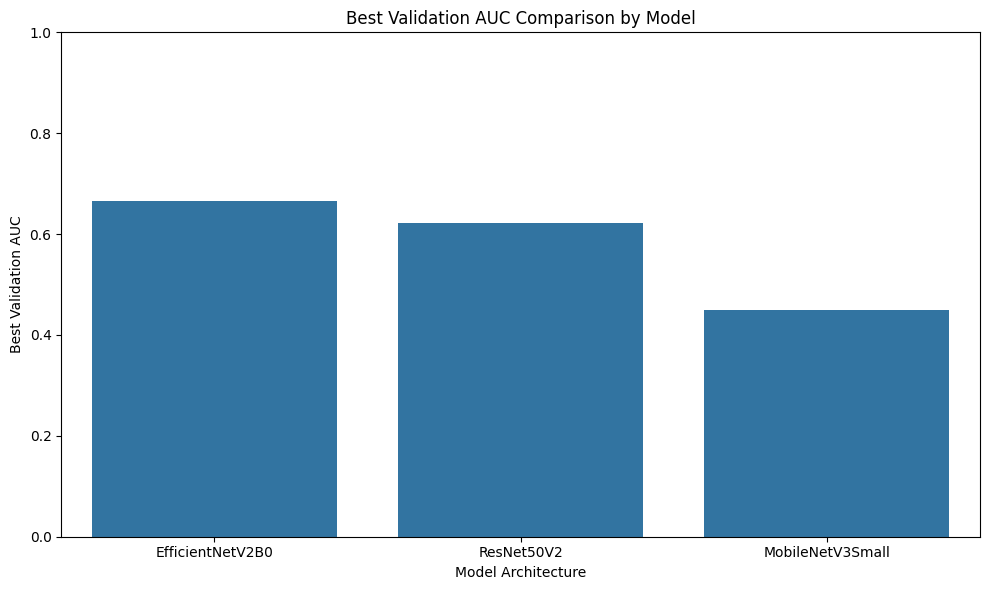


--- Best Performing Model: EfficientNetV2B0 ---


In [24]:
import seaborn as sns # Make sure seaborn is imported
import matplotlib.pyplot as plt # Make sure matplotlib.pyplot is imported


# 3. 定义要比较的模型
# 选择一些轻量级且性能优秀的基础模型
models_to_try = ['MobileNetV3Small', 'EfficientNetV2B0', 'ResNet50V2']
histories = {}
best_model = None # Variable to store the best model instance
best_model_base_model = None # Variable to store the base model instance of the best model
best_mode_history = None
best_overall_auc = 0.0 # Variable to track the best AUC found so far


# 4. 构建数据增强
augmentation_model = build_augmentation_model()


# 5. 循环训练和评估模型
print("Starting model training loop...")

# 定义回调
callbacks = [
    # 监控 val_auc，5 个 epoch 没有提升就停止
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=5,
        mode='max',
        restore_best_weights=True
    ),
    # 当 val_auc 停滞时，自动降低学习率
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.2,
        patience=2,
        mode='max'
    )
]

for model_name in models_to_try:
    print(f"\n--- Training {model_name} ---")
    # 清理 Keras 会话，释放内存
    keras.utils.clear_session()

    # Modify build_model to return both model and base_model instance
    # Assuming build_model and augmentation_model functions are defined in previous executed cells
    model, base_model_instance = build_model(model_name, augmentation_model) # Capture the returned base_model instance

    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1  # 打印进度
    )

    histories[model_name] = history
    best_val_auc = max(history.history['val_auc'])
    print(f"--- Best Validation AUC for {model_name}: {best_val_auc:.5f} ---")

    # Track the best model and its base model instance
    if best_val_auc > best_overall_auc:
        best_overall_auc = best_val_auc
        best_model_name = model_name
        best_model = model # Store the best model instance
        best_model_base_model = base_model_instance # Store the base model instance
        best_model_history = history # Store the history of the best model


# 6. 总结结果并可视化
print("\n--- Model Comparison Summary ---")
summary_results = {}
for model_name, history in histories.items():
    best_auc = max(history.history['val_auc'])
    summary_results[model_name] = best_auc


# Display results as a pandas DataFrame (table)
print("\nBest Validation AUC by Model (Table):")
summary_df = pd.DataFrame(list(summary_results.items()), columns=['Model', 'Best_Val_AUC'])
display(summary_df.sort_values(by='Best_Val_AUC', ascending=False))

# Visualize results as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Best_Val_AUC', data=summary_df.sort_values(by='Best_Val_AUC', ascending=False))
plt.title('Best Validation AUC Comparison by Model')
plt.ylabel('Best Validation AUC')
plt.xlabel('Model Architecture')
plt.ylim(0, 1) # AUC is between 0 and 1
plt.tight_layout()
plt.show()


print(f"\n--- Best Performing Model: {best_model_name} ---")
# best_model and best_model_base_model are now available globally for fine-tuning

## 5. Fine-Tuning to get better AOC score
Fine-Tuning the best model we got from prvious stpes.

In [25]:
def plot_history(history_phase1, history_phase2, initial_epochs):
    """
    绘制两个阶段的训练历史。
    """
    # 提取指标
    acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
    val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']

    loss = history_phase1.history['loss'] + history_phase2.history['loss']
    val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

    auc = history_phase1.history['auc'] + history_phase2.history['auc']
    val_auc = history_phase1.history['val_auc'] + history_phase2.history['val_auc']

    plt.figure(figsize=(18, 6))

    # 绘制 AUC
    plt.subplot(1, 3, 1)
    plt.plot(auc, label='Training AUC')
    plt.plot(val_auc, label='Validation AUC')
    plt.axvline(initial_epochs - 1, linestyle='--', color='k', label='Start Fine-Tuning')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # 绘制 Loss
    plt.subplot(1, 3, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(initial_epochs - 1, linestyle='--', color='k', label='Start Fine-Tuning')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # 绘制 Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(initial_epochs - 1, linestyle='--', color='k', label='Start Fine-Tuning')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.tight_layout()
    # 在 Colab 中，这会自动显示图像
    plt.show()





--- Phase 1: Training Head (Frozen Base) for 10 epochs ---
--- Best Validation AUC after Phase 1: 0.66563 ---

--- Phase 2: Fine-Tuning (Unfrozen Base) for 15 epochs ---
Unfreezing base model: efficientnetv2-b0
Total layers in base model: 271
Unfreezing top 54 layers (20.0%)
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 89s 89s/step - accuracy: 0.5575 - auc: 0.5728 - loss: 0.8348 - val_accuracy: 0.5682 - val_auc: 0.6739 - val_loss: 0.6412 - learning_rate: 1.0000e-05
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.5000 - auc: 0.4938 - loss: 0.9674 - val_accuracy: 0.6136 - val_auc: 0.7122 - val_loss: 0.6333 - learning_rate: 1.0000e-05
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5057 - auc: 0.5250 - loss: 0.9064 - val_accuracy: 0.6818 - val_auc: 0.7153 - val_loss: 0.6341 - learning_rate: 1.0000e-05
Epoch 14/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.4368 - auc: 0.4323 - loss: 0.9960 - val_accuracy: 0.7273 - val_auc: 0.7091 - val_loss: 0.6382 - learn

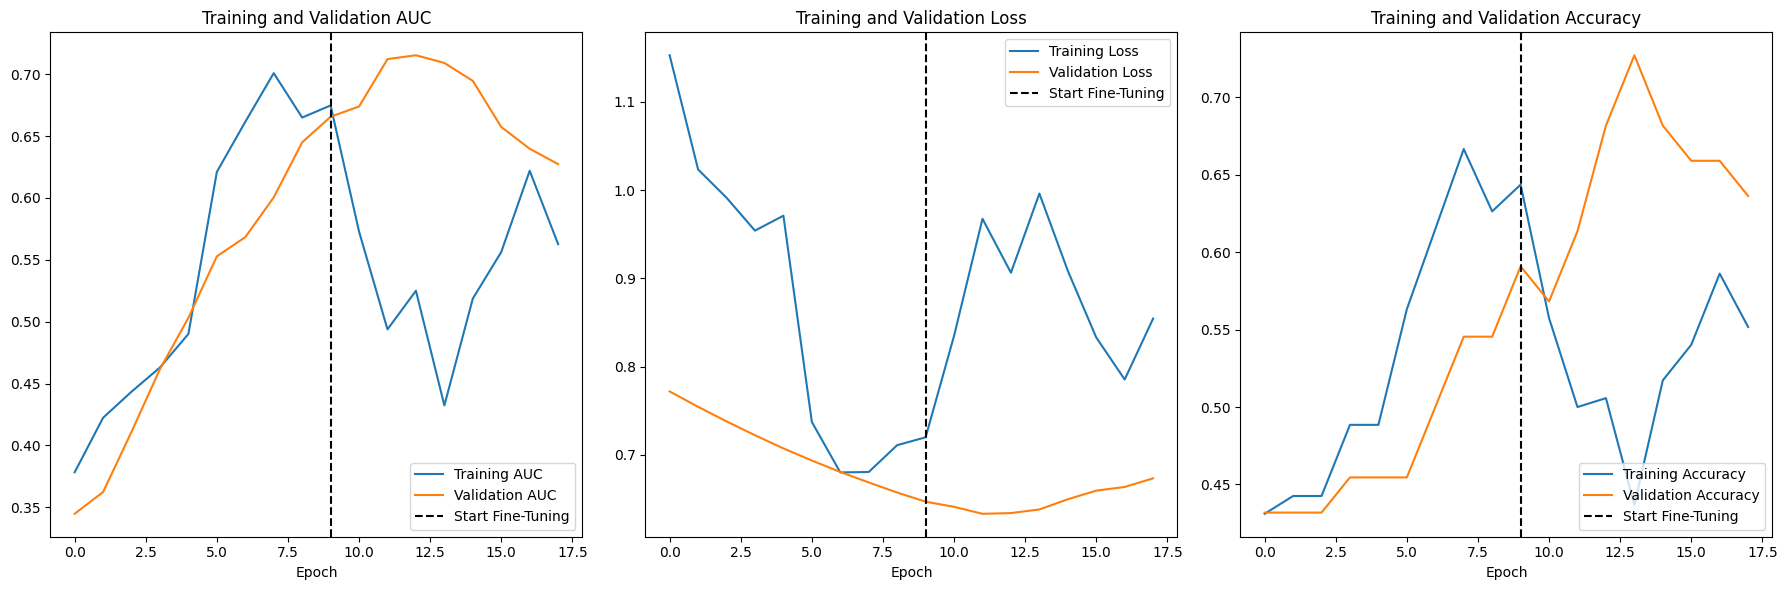


Step 2 (Fine-Tuning) Complete.
Next steps: Try unfreezing more layers (increase FINE_TUNE_LAYERS_PERCENTAGE),
or try Test Time Augmentation (TTA) on your best model.


In [28]:


# 训练阶段的 Epochs
INITIAL_EPOCHS = 10  # 阶段 1 (冻结) 的 Epochs (与你之前运行的一致)
FINE_TUNE_EPOCHS = 15 # 阶段 2 (精调) 的 Epochs
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# 精调超参数
FINE_TUNE_LEARNING_RATE = 1e-5 # 精调时必须使用非常低的学习率
INITIAL_LEARNING_RATE = 1e-3 # 初始训练学习率
FINE_TUNE_LAYERS_PERCENTAGE = 0.2 # 解冻主干网络顶部 20% 的层



# 3. 构建数据增强和模型
# model, base_model = build_model(best_model_name, augmentation_model)
# model.summary()

# # 4. 定义回调 (用于两个阶段)
# callbacks = [
#     # 监控 val_auc，耐心设为 5
#     keras.callbacks.EarlyStopping(
#         monitor='val_auc',
#         patience=5, # 两个阶段共用
#         mode='max',
#         restore_best_weights=True
#     ),
#     # 学习率调度器在精调阶段非常有用
#     keras.callbacks.ReduceLROnPlateau(
#         monitor='val_auc',
#         factor=0.2,
#         patience=2,
#         mode='max',
#         min_lr=1e-7 # 确保学习率不会降得太低
#     )
# ]

# # --- 阶段 1: 特征提取 (训练头部) ---
# print(f"\n--- Phase 1: Training Head (Frozen Base) for {INITIAL_EPOCHS} epochs ---")
# history_phase1 = model.fit(
#     train_dataset,
#     epochs=INITIAL_EPOCHS,
#     validation_data=val_dataset,
#     callbacks=callbacks,
#     verbose=1
# )

# best_val_auc_phase1 = max(history_phase1.history['val_auc'])
# print(f"--- Best Validation AUC after Phase 1: {best_val_auc_phase1:.5f} ---")

print(f"\n--- Phase 1: Training Head (Frozen Base) for {INITIAL_EPOCHS} epochs ---")
history_phase1 = best_model_history
best_val_auc_phase1 = max(history_phase1.history['val_auc'])
print(f"--- Best Validation AUC after Phase 1: {best_val_auc_phase1:.5f} ---")

print(f"\n--- Phase 2: Fine-Tuning (Unfrozen Base) for {FINE_TUNE_EPOCHS} epochs ---")

# 1. 解冻主干网络
# **修改**: 直接使用我们保存的 base_model 引用
# 不再需要 model.get_layer()
print(f"Unfreezing base model: {best_model_base_model.name}")
best_model_base_model.trainable = True

# 2. 决定解冻多少层
total_layers = len(best_model_base_model.layers)
layers_to_unfreeze = int(total_layers * FINE_TUNE_LAYERS_PERCENTAGE)

print(f"Total layers in base model: {total_layers}")
print(f"Unfreezing top {layers_to_unfreeze} layers ({FINE_TUNE_LAYERS_PERCENTAGE * 100}%)")

# 3. 冻结底部的层，只解冻顶部的层
# **高级技巧**: 保持 BatchNormalization 层冻结
for i, layer in enumerate(base_model.layers):
    if i < total_layers - layers_to_unfreeze:
        layer.trainable = False
    else:
        # 解冻层，但保持 BN 层冻结
        if isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True


# 4. 重新编译模型，使用极低的学习率
optimizer = keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE)

best_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
    ]
)

# best_mode.summary() # 再次打印摘要，查看可训练参数的变化

# 5. 继续训练 (精调)
# 注意：fit 会从模型离开的地方继续
history_phase2 = best_model.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS, # 总共训练的 epochs
    initial_epoch=history_phase1.epoch[-1] + 1, # 从上一个阶段结束的地方开始
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

# 6. 总结结果
best_val_auc_phase2 = max(history_phase2.history.get('val_auc', [0.0]))
print(f"\n--- Fine-Tuning Complete ---")
print(f"Best Validation AUC (Phase 1): {best_val_auc_phase1:.5f}")
print(f"Best Validation AUC (Phase 2): {best_val_auc_phase2:.5f}")

# 7. 绘制训练历史
print("Plotting training history...")
plot_history(history_phase1, history_phase2, INITIAL_EPOCHS)

print("\nStep 2 (Fine-Tuning) Complete.")
print("Next steps: Try unfreezing more layers (increase FINE_TUNE_LAYERS_PERCENTAGE),")
print("or try Test Time Augmentation (TTA) on your best model.")



## AI tools usage declaration